In [24]:
# Importa TensorFlow con el alias 'tf'
import tensorflow as tf

# Importa el módulo 'os' para interactuar con el sistema operativo
import os

# Importa la clase 'ImageDataGenerator' para generar lotes de imágenes aumentadas
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importa clases específicas para construir modelos de redes neuronales con Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Importa la biblioteca 'matplotlib' para visualización de gráficos
import matplotlib.pyplot as plt

# Importa el módulo de preprocesamiento de imágenes de Keras
from tensorflow.keras.preprocessing import image

# Importa NumPy para operaciones numéricas eficientes
import numpy as np

# Importa funciones relacionadas con la matriz de confusión de scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Importa funciones para calcular la curva ROC y el área bajo la curva (AUC)
from sklearn.metrics import roc_curve, auc

In [3]:
# Definir rutas a los conjuntos de datos
tea_dir = 'AutismDataset/consolidated/tea'
no_tea_dir = 'AutismDataset/consolidated/no_tea'

In [4]:
# Definir dimensiones de las imágenes y otros parámetros
img_width, img_height = 64, 64
batch_size = 32
epochs = 10

In [5]:
# Configurar generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'AutismDataset/consolidated',  # Ruta principal de los datos
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'AutismDataset/consolidated',  # Ruta principal de los datos
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 2352 images belonging to 2 classes.
Found 588 images belonging to 2 classes.


In [6]:
# Construir el modelo
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [7]:
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Entrenar el modelo
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10


74/74 [==============================] - 13s 157ms/step - loss: 0.6180 - accuracy: 0.6467 - val_loss: 0.6435 - val_accuracy: 0.6361
Epoch 2/10
74/74 [==============================] - 10s 131ms/step - loss: 0.5364 - accuracy: 0.7377 - val_loss: 0.6894 - val_accuracy: 0.6463
Epoch 3/10
74/74 [==============================] - 11s 148ms/step - loss: 0.5212 - accuracy: 0.7466 - val_loss: 0.7099 - val_accuracy: 0.6259
Epoch 4/10
74/74 [==============================] - 10s 137ms/step - loss: 0.4778 - accuracy: 0.7798 - val_loss: 0.7119 - val_accuracy: 0.6514
Epoch 5/10
74/74 [==============================] - 12s 165ms/step - loss: 0.4351 - accuracy: 0.8010 - val_loss: 0.5910 - val_accuracy: 0.6939
Epoch 6/10
74/74 [==============================] - 14s 184ms/step - loss: 0.3965 - accuracy: 0.8180 - val_loss: 0.6453 - val_accuracy: 0.6752
Epoch 7/10
74/74 [==============================] - 13s 176ms/step - loss: 0.3696 - accuracy: 0.8308 - val_loss: 0.6139 - val_accuracy: 0.70

In [9]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Precisión del modelo en el conjunto de prueba: {test_accuracy * 100:.2f}%')

19/19 [==============================] - 2s 85ms/step - loss: 0.7698 - accuracy: 0.6718
Precisión del modelo en el conjunto de prueba: 67.18%


In [10]:
# Guardar el modelo entrenado
model.save('modelo_tea_detector.keras')

In [11]:
# Función para cargar y preprocesar una imagen
def load_and_preprocess_image(img_path, target_size=(img_width, img_height)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalizar la imagen
    return img, img_array

In [12]:
# Ruta de la carpeta de prueba
test_folder = 'AutismDataset/test'

In [13]:
# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('modelo_tea_detector.keras')

In [14]:
# Obtener la lista de archivos en la carpeta de prueba
test_files = os.listdir(test_folder)

In [15]:
# Inicializar contadores
tea_count = 0
no_tea_count = 0

In [16]:
# Listas para la matriz de confusión
true_labels = []
predicted_labels = []

In [17]:
# Realizar predicciones y contar las imágenes
for file in test_files:
    img_path = os.path.join(test_folder, file)
    img, img_array = load_and_preprocess_image(img_path)
    true_label = 1 if 'Tea' in file else 0  
    true_labels.append(true_label)

    # Realizar la predicción
    prediction = loaded_model.predict(img_array)
    predicted_label = 1 if prediction[0][0] > 0.5 else 0
    predicted_labels.append(predicted_label)

    # Incrementar el contador correspondiente
    if predicted_label == 1:
        tea_count += 1
    else:
        no_tea_count += 1

1/1 [==============================] - 0s 24ms/step


In [18]:
# Imprimir falsos positivos y falsos negativos
conf_matrix = confusion_matrix(true_labels, predicted_labels)
tn, fp, fn, tp = conf_matrix.ravel()
print(f'Falsos Positivos (FP): {fp}')
print(f'Falsos Negativos (FN): {fn}')

Falsos Positivos (FP): 131
Falsos Negativos (FN): 0


In [21]:
# Métricas
specificity = tn / (tn + fp)

In [22]:
# Manejar la división por cero para sensibilidad (sensitivity)
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

ppv = tp / (tp + fp)
npv = tn / (tn + fn)

In [25]:
# Calcular curva ROC y AUC
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

C:\Users\arthu\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [26]:
# Imprimir resultados
print(f'Especificidad (Spec.): {specificity:.4f}')
print(f'Sensibilidad (Sens.): {sensitivity:.4f}')
print(f'Valor Predictivo Positivo (VPP): {ppv:.4f}')
print(f'Valor Predictivo Negativo (VPN): {npv:.4f}')
print(f'Área bajo la curva ROC (AUC): {roc_auc:.4f}')

Especificidad (Spec.): 0.5633
Sensibilidad (Sens.): 0.0000
Valor Predictivo Positivo (VPP): 0.0000
Valor Predictivo Negativo (VPN): 1.0000
Área bajo la curva ROC (AUC): nan


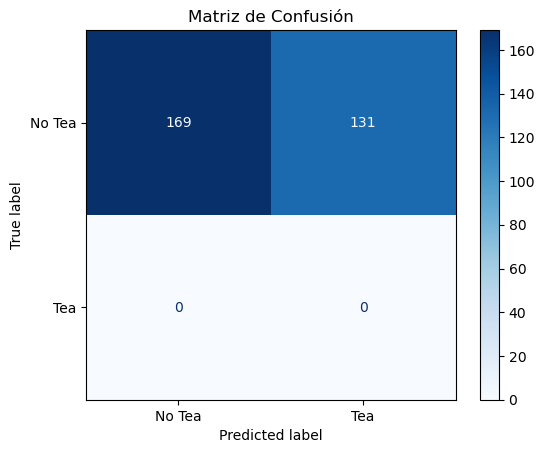

In [27]:
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['No Tea', 'Tea'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

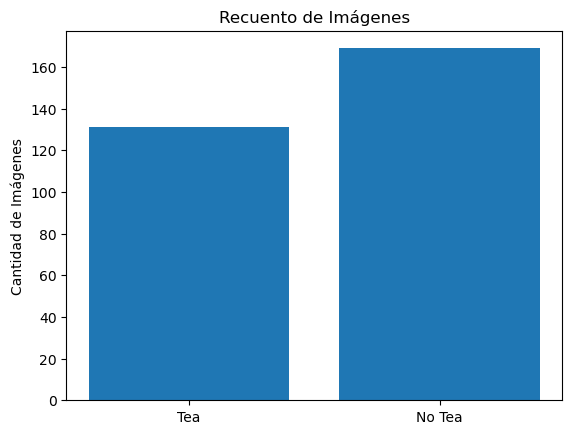

In [30]:
# Crear una figura y mostrar el recuento
fig, ax = plt.subplots()
ax.bar(['Tea', 'No Tea'], [tea_count, no_tea_count])
ax.set_ylabel('Cantidad de Imágenes')
ax.set_title('Recuento de Imágenes')
plt.show()

In [29]:
# Evaluar el modelo en el conjunto de entrenamiento
test_loss, test_accuracy = model.evaluate(train_generator)
print(f'Precisión del modelo en el conjunto de entrenamiento: {test_accuracy * 100:.2f}%')

74/74 [==============================] - 7s 92ms/step - loss: 0.1994 - accuracy: 0.9192
Precisión del modelo en el conjunto de prueba: 91.92%
